In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/housing.csv')

In [4]:
df.head(5)

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [5]:
X = df.values[:,:-1]
y = df.values[:, -1]

In [8]:
class LinearRegression:
    def __init__(self, X, y, max_iteration, epsilon, learning_rate, gd=True) -> None:
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.gd = gd

    def split_data(self):
      X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                          self.y,
                                                          test_size=0.3,
                                                          shuffle= True)
      return X_train, X_test, y_train, y_test

    def add_X0(self, X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self,X):
      mean = np.mean(X, axis = 0)
      std = np.std(X, axis = 0)
      X = (X - mean) / std
      X = self.add_X0(X)
      return X, mean, std

    def normalize_test(self, X, mean, std):
      X = (X - mean) / std
      X = self.add_X0(X)
      return X

    def rank(self, X):
      u, s, v = np.linalg.svd(X)

      #rank = np.linalg.matrix_rank(X)
      return len([x for x in s if x > 0.0005])

    def check_fullRank(self,X):
      rank = self.rank(X)
      if rank == min(X.shape):
        self.full_rank = True
        print("it is full rank")
      else:
        self.full_rank = False
        print("it is not full rank")

    def check_lowRank(self, X):
      if X.shape[0] < X.shape[1]:
        self.low_rank = True
        print("it is low rank")
      else:
        self.low_rank = False
        print("it is not low rank")

    def closed_form_solution(self, X, y):
      self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
      return self.theta

    def predict(self, X):
      return X.dot(self.theta)

    def sse(self, X, y):
      y_hat = self.predict(X)
      return ((y_hat - y) ** 2).sum()

    def cost_function(self, X, y):
      loss = self.sse(X, y)
      return loss / 2

    def cost_derivative(self, X, y):
      y_hat = self.predict(X)
      return X.T.dot(y_hat - y)

    def gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(X, y)
        error = self.cost_function(X, y)
        errors.append(error)

        # loss = self.sse(X, y)
        # errors.append(loss)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

        # prev_error = loss
      self.plot_rmse(errors)

    def fit(self):
      X_train, X_test, y_train, y_test = self.split_data()
      X_train, mean, std = self. normalize_train(X_train)
      X_test = self.normalize_test(X_test, mean, std)
      self.check_fullRank(X_train)
      self.check_lowRank(X_train)

      if self.full_rank and not self.low_rank and X_train.shape[1] < 1000 and not self.gd:
          self.closed_form_solution(X_train, y_train)
      else:
        self.theta = np.ones(X_train.shape[1])
        self.gradient_descent (X_train, y_train)

      print(self.theta)


    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=list(range(len(error_sequence))))
        ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()



it is full rank
it is not low rank


100%|██████████| 1000/1000 [00:00<00:00, 8260.68it/s]


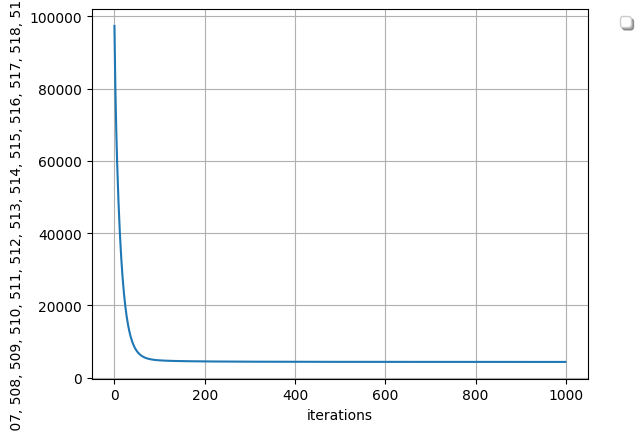

[22.76968839 -0.81308658  1.14654437  0.08322187  0.70762572 -1.91549772
  2.49962008  0.09168488 -3.21194154  2.72871721 -2.20505887 -2.25694388
  0.79593843 -4.16421319]


In [21]:
# lr = LinearRegression(X, y, max_iteration=50000, epsilon=0.0003, learning_rate=0.000001,gd = False)
lr = LinearRegression(X, y, max_iteration=1000, epsilon=0.0003, learning_rate=0.0001,gd = True)
lr.fit()